<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://docs.unidata.ucar.edu/images/logos/unidata_logo_vertical_150x150.png" alt="Unidata Logo" style="height: 98px;">
</div>

# Colored Surface Temperature
**Python-AWIPS Tutorial Notebook**

<div style="clear:both"></div>
</div>

---

<div style="float:right; width:250 px"><img src="../images/colored_surface_temp_preview.png" alt="[image text]" style="height: 300px;"></div>


# Objectives

* Use python-awips to connect to an edex server
* Define and filter data request for METAR surface obs
* Define a color threshold and use it to plot a useful map
* Create a product similar to existing products in GEMPAK and CAVE

---

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Initial-Setup" data-toc-modified-id="Initial-Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Initial Setup</a></span><ul class="toc-item"><li><span><a href="#Geographic-Filter" data-toc-modified-id="Geographic-Filter-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Geographic Filter</a></span></li><li><span><a href="#EDEX-Connection" data-toc-modified-id="EDEX-Connection-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>EDEX Connection</a></span></li></ul></li><li><span><a href="#Filter-by-Time" data-toc-modified-id="Filter-by-Time-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Filter by Time</a></span></li><li><span><a href="#Access-and-Convert-Temp-Data" data-toc-modified-id="Access-and-Convert-Temp-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Access and Convert Temp Data</a></span></li><li><span><a href="#Define-Temperature-Thresholds" data-toc-modified-id="Define-Temperature-Thresholds-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Define Temperature Thresholds</a></span></li><li><span><a href="#Plot-the-Data!" data-toc-modified-id="Plot-the-Data!-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Plot the Data!</a></span></li><li><span><a href="#See-Also" data-toc-modified-id="See-Also-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>See Also</a></span><ul class="toc-item"><li><span><a href="#Additional-Documention" data-toc-modified-id="Additional-Documention-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Additional Documention</a></span></li></ul></li></ul></div>

## Imports

The imports below are used throughout the notebook.  Note the first import is coming directly from python-awips and allows us to connect to an EDEX server.  The subsequent imports are for data manipulation and visualization. 

In [1]:
from awips.dataaccess import DataAccessLayer
from dynamicserialize.dstypes.com.raytheon.uf.common.time import TimeRange
from datetime import datetime, timedelta
import numpy as np
import cartopy.crs as ccrs
import warnings
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from metpy.plots import StationPlot

<a href="#top">Top</a>

---

## Initial Setup

### Geographic Filter

By defining a bounding box for the Continental US (CONUS), we're able to optimize the data request sent to the EDEX server.

In [2]:
# CONUS bounding box and envelope geometry
bbox=[-130, -70, 15, 55]
envelope = Polygon([(bbox[0],bbox[2]),(bbox[0],bbox[3]),
                    (bbox[1], bbox[3]),(bbox[1],bbox[2]),
                    (bbox[0],bbox[2])])

### EDEX Connection

First we establish a connection to Unidata's public EDEX server.  With that connection made, we can create a [new data request object](http://unidata.github.io/python-awips/api/IDataRequest.html) and set the data type to ***obs***, and use the geographic ***envelope*** we just created.

In [3]:
# New obs request
edexServer = "edex-cloud.unidata.ucar.edu"
DataAccessLayer.changeEDEXHost(edexServer)
request = DataAccessLayer.newDataRequest("obs", envelope=envelope)
params = ["temperature", "longitude", "latitude", "stationName"]
request.setParameters(*(params))

<a href="#top">Top</a>

---

## Filter by Time

We then want to limit our results based on time, so we create a time range for the last 15 minutes, and then send the request to the EDEX server to get our results, which are kept in the **obs** variable.

In [4]:
# Get records from the last 15 minutes
lastHourDateTime = datetime.utcnow() - timedelta(minutes = 15)
start = lastHourDateTime.strftime('%Y-%m-%d %H:%M:%S')
end = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')

beginRange = datetime.strptime( start , "%Y-%m-%d %H:%M:%S")
endRange = datetime.strptime( end , "%Y-%m-%d %H:%M:%S")
timerange = TimeRange(beginRange, endRange)
# Get response
response = DataAccessLayer.getGeometryData(request,timerange)
obs = DataAccessLayer.getMetarObs(response)

lats = obs['latitude']
lons = obs['longitude']

print("Found " + str(len(response)) + " total records")
print("Using " + str(len(obs['temperature'])) + " temperature records")

Found 967 total records
Using 944 temperature records


<a href="#top">Top</a>

---

## Access and Convert Temp Data

We access the *temperature* data from the **obs** variable which is stored in degrees Celsius (°C).  To make it more relatable, we then convert the data to degrees Fahreheit (°F)

In [5]:
# # Suppress nan masking warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)

# get all temperature values and convert them from °C to °F
tair = np.array(obs['temperature'], dtype=float)
tair[tair == -9999.0] = 'nan'
tair = (tair*1.8)+32

<a href="#top">Top</a>

---

## Define Temperature Thresholds

In order to distinguish the temperatures, we'll create a color map to separate the values into different colors.  This mapping will be used when plotting the temperature values on the map of the United States.

<div class="alert-info">
<b>Tip:</b>  Try playing around with the color ranges and see how that affects the final plot.
</div>

In [6]:
thresholds = {
    '15': 'purple',
    '25': 'c',
    '35': 'royalblue',
    '45': 'darkgreen', 
    '55': 'green',
    '65': 'y', 
    '75': 'orange',
    '85': 'red'
}

<a href="#top">Top</a>

---

## Plot the Data!

Here we create a plot and cycle through all the values from our color mapping.  For each segement of our color mapping, mask the temperature values to only include the relevent temperatures and draw those on the plot.  Do this for every segment of the color mapping to produce the final, colored figure.

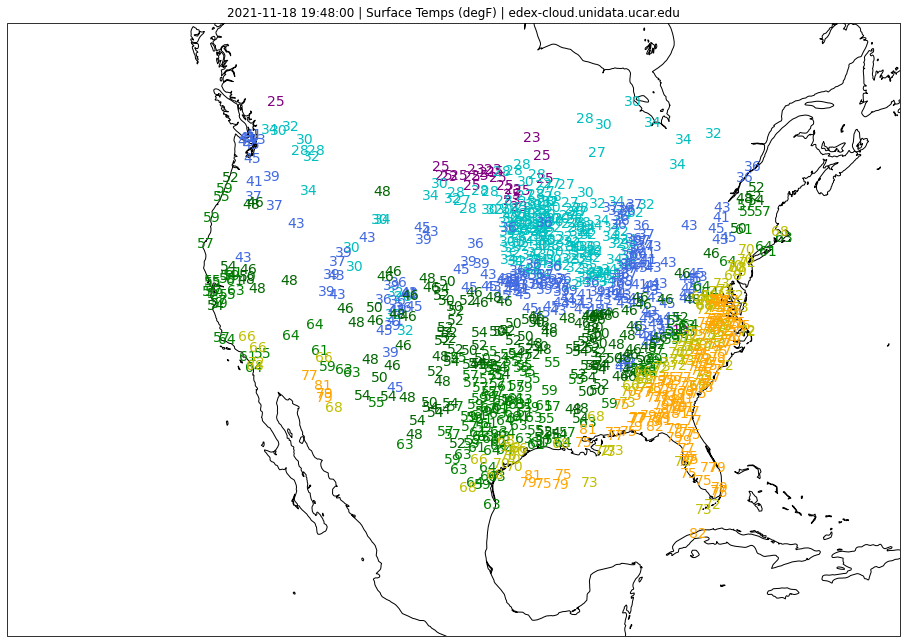

In [7]:
fig, ax = plt.subplots(figsize=(16,12),subplot_kw=dict(projection=ccrs.LambertConformal()))
ax.set_extent(bbox)
ax.coastlines(resolution='50m')
ax.set_title(str(response[-1].getDataTime()) + " | Surface Temps (degF) | " + edexServer)

# get the temperature limit (x) and color (value)
for x, value in thresholds.items():
    # create a new temperature value array
    subtair = tair.copy()

    # pair down the temperature values to a subset
    if x==max(thresholds):
        subtair[(subtair < int(x))] = 'nan'
    elif x==min(thresholds):
        subtair[(subtair >= int(x)+10)] = 'nan'
    else:
        subtair[(subtair < int(x))] = 'nan'
        subtair[(subtair >= int(x)+10)] = 'nan'

    # add these stations and their color to the stationplots
    stationplot = StationPlot(ax, lons, lats, transform=ccrs.PlateCarree(), fontsize=14)
    stationplot.plot_parameter('C', subtair, color=value)   


<a href="#top">Top</a>

---

## See Also


### Additional Documention

**python-awips**

- [DataAccessLayer.changeEDEXHost()](http://unidata.github.io/python-awips/api/DataAccessLayer.html#awips.dataaccess.DataAccessLayer.changeEDEXHost)
- [DataAccessLayer.newDataRequest()](http://unidata.github.io/python-awips/api/DataAccessLayer.html#awips.dataaccess.DataAccessLayer.newDataRequest)

**matplotlib**

- [matplotlib.pyplot()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html)
- [matplotlib.pyplot.axes()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axes.html)
- [matplotlib.pyplot.figure()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html)

<a href="#top">Top</a>

---